In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

In [2]:
tf.__version__

'2.0.0-alpha0'

In [3]:
!python -V

Python 3.7.3


In [4]:
data = pd.read_csv("/home/jagadeesh/DS/FB.csv",parse_dates=['Date'],index_col='Date')

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [6]:
def make_dataset(array,time_steps):

    x = []
    y = []

    for i in range(time_steps,len(array)):
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

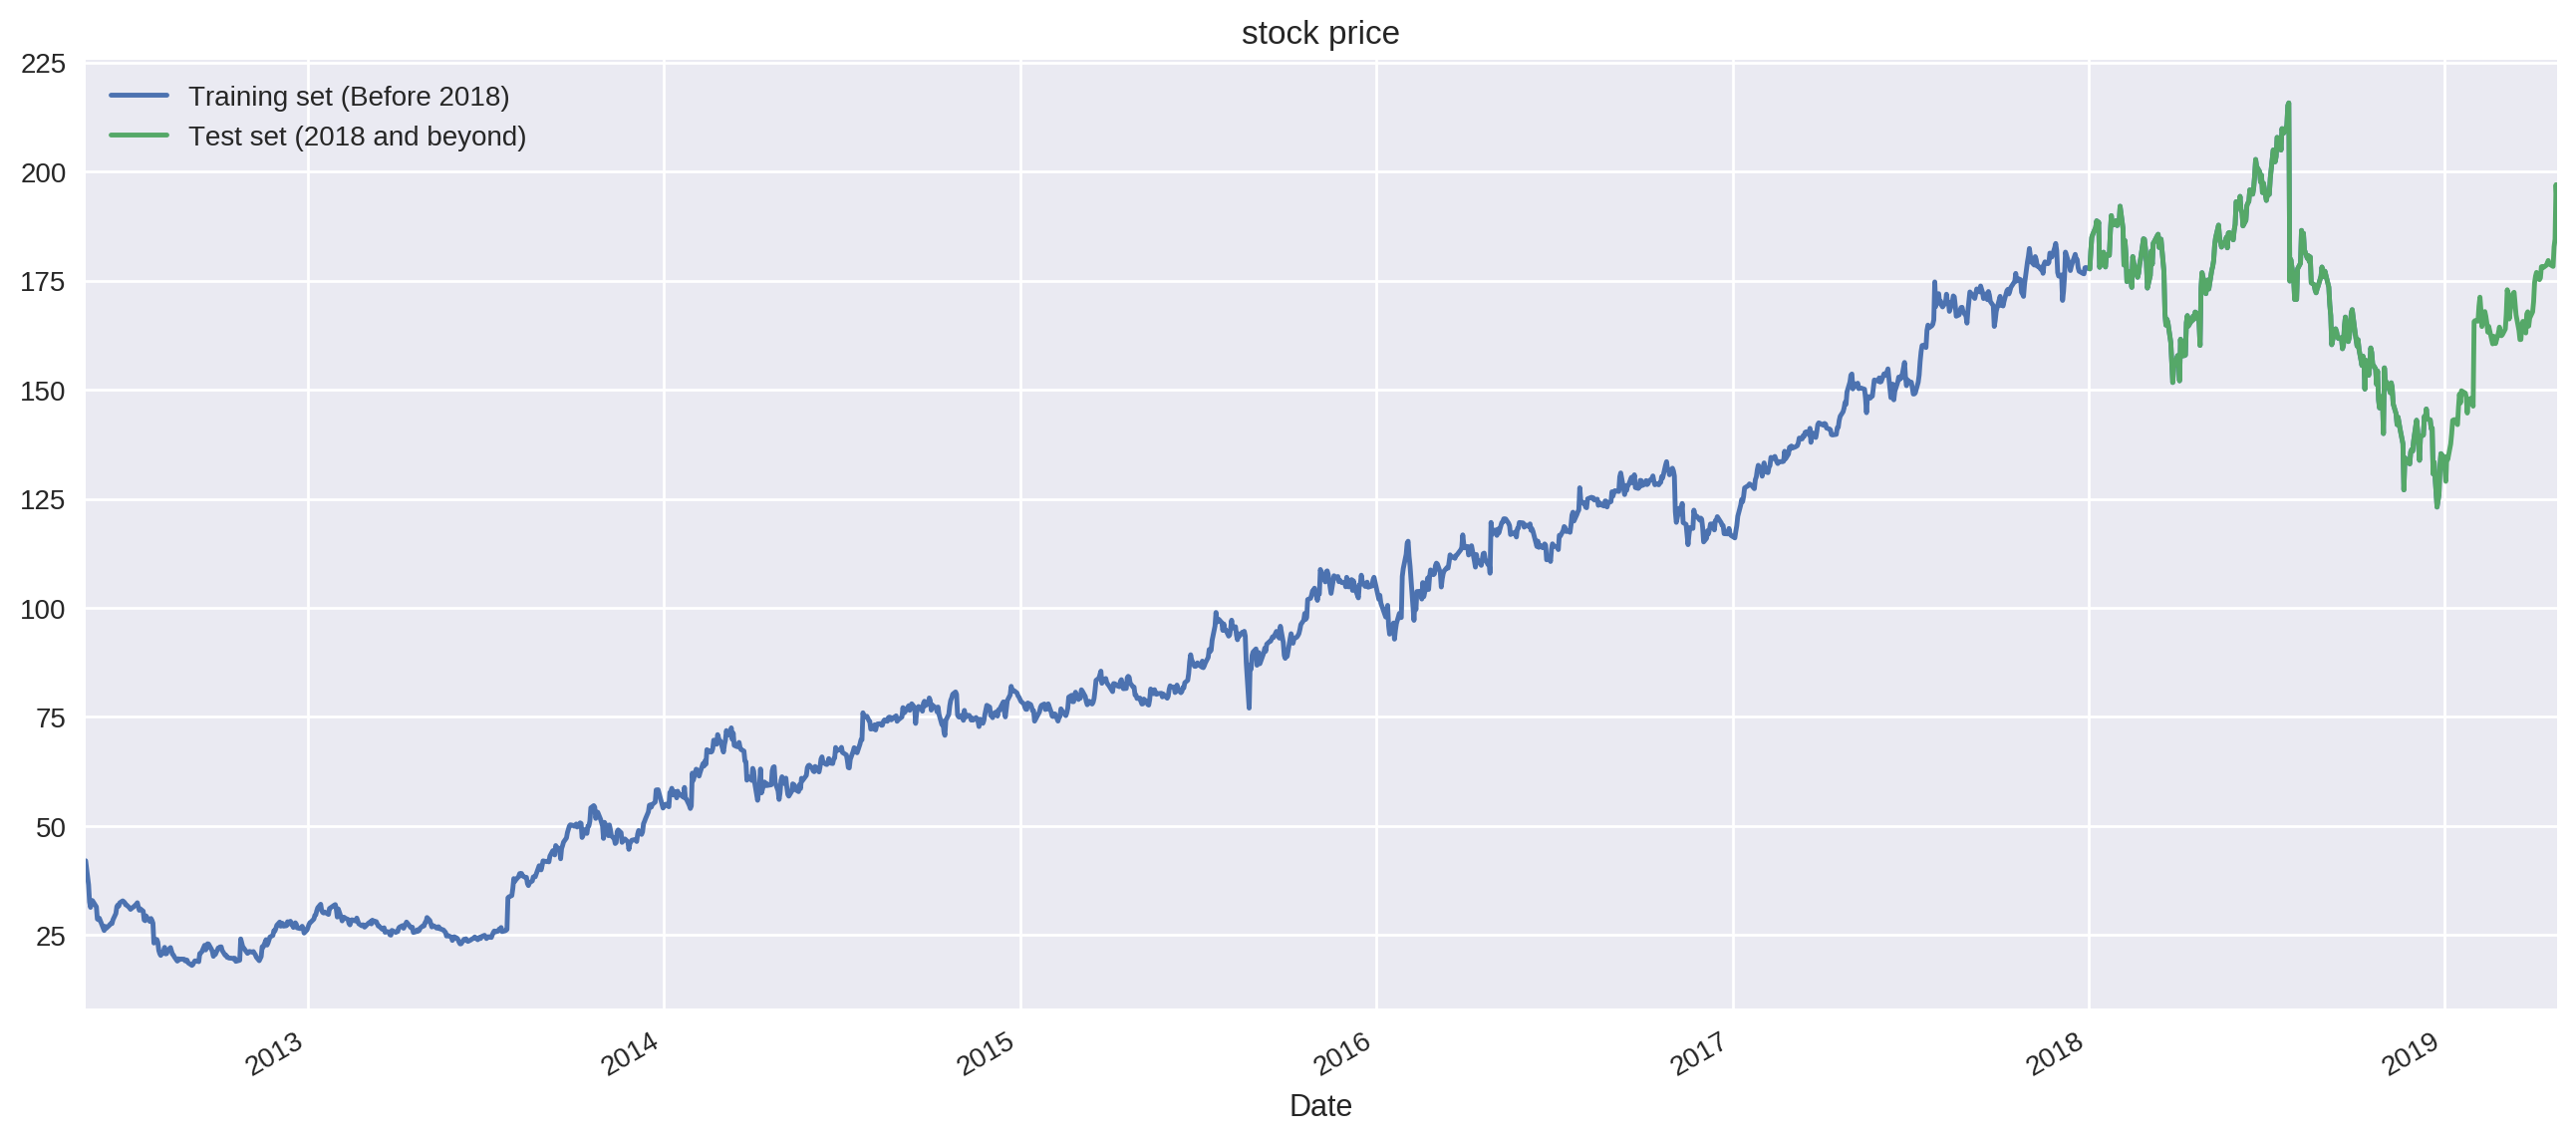

In [7]:
plt.figure(dpi=200,figsize=(16,7))
data["Open"][:'2018'].plot(legend=True)
data["Open"]['2018':].plot(legend=True)
plt.legend(['Training set (Before 2018)','Test set (2018 and beyond)'])
plt.title('stock price')
plt.show()

In [8]:
train = data[:"2018"]["Open"].values


scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train.reshape(-1,1))

trn_x,trn_y = make_dataset(train,60)

## The three dimensions of this input are:

* **Samples**. One sequence is one sample. A batch is comprised of one or more samples.
* **Time Steps**. One time step is one point of observation in the sample.
* **Features**. One feature is one observation at a time step.

In [9]:
trn_x = trn_x.reshape(-1,60,1)

### Model Architecture

* LSTM(50)
* LSTM(50)
* LSTM(50)
* Dense(500)
* Dropout(0.2)
* Dense(1)

In [10]:
model = tf.keras.models.Sequential()

model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, return_sequences=True))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, return_sequences=True))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50))

model.add(tf.keras.layers.Dense(500))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=50)
model.compile(optimizer='adam', loss='mse')

In [11]:
model.fit(trn_x, trn_y, epochs=50)

Epoch 1/50
1605/1605 [==============================] - 2s 1ms/sample - loss: 0.0208
Epoch 2/50
1605/1605 [==============================] - 0s 274us/sample - loss: 0.0012
Epoch 3/50
1605/1605 [==============================] - 0s 296us/sample - loss: 0.0011
Epoch 4/50
1605/1605 [==============================] - 0s 286us/sample - loss: 9.1412e-04
Epoch 5/50
1605/1605 [==============================] - 0s 279us/sample - loss: 0.0011
Epoch 6/50
1605/1605 [==============================] - 0s 309us/sample - loss: 0.0010
Epoch 7/50
1605/1605 [==============================] - 1s 329us/sample - loss: 9.0175e-04
Epoch 8/50
1605/1605 [==============================] - 0s 300us/sample - loss: 9.1969e-04
Epoch 9/50
1605/1605 [==============================] - 0s 285us/sample - loss: 9.0625e-04
Epoch 10/50
1605/1605 [==============================] - 0s 301us/sample - loss: 9.8233e-04
Epoch 11/50
1605/1605 [==============================] - 0s 291us/sample - loss: 7.4803e-04
Epoch 12/50
1605/16

In [12]:
total = data['Open'].values
total_scaled = scaler.transform(total.reshape(-1,1))

total_x,total_y = make_dataset(total_scaled,60)

In [13]:
predicted = model.predict(total_x)
predicted = scaler.inverse_transform(predicted)

Text(0, 0.5, 'Price')

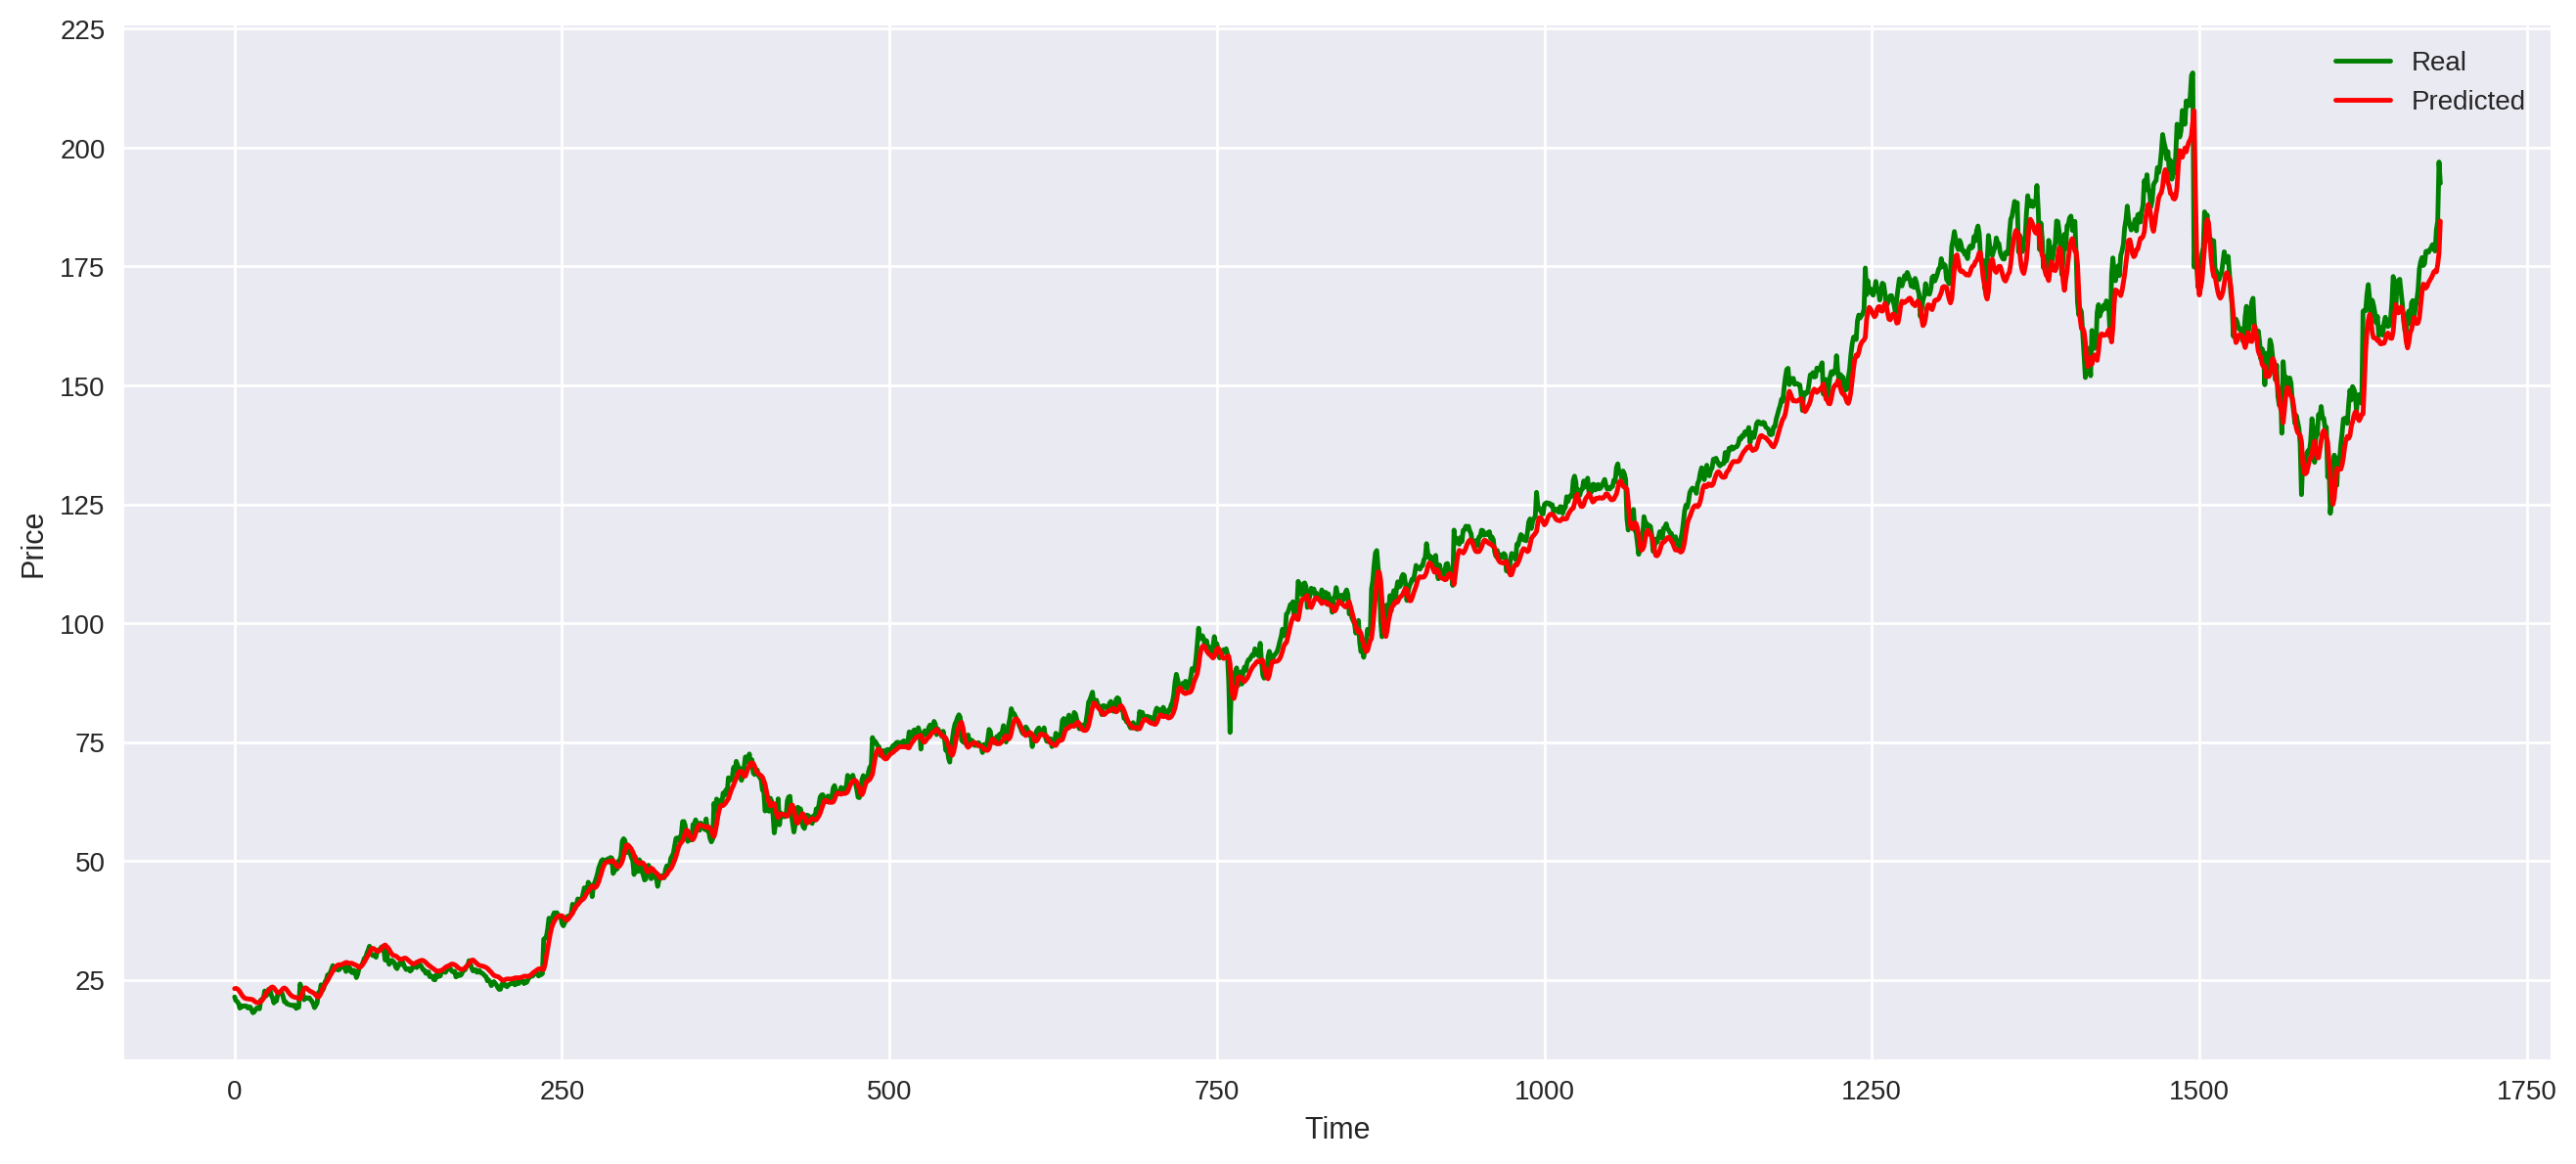

In [14]:
plt.figure(figsize=(16,7),dpi=200)
plt.plot(data['Open'].iloc[60:].values,label='Real',color='green')
plt.plot(predicted,label='Predicted',color='red')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Price')

In [15]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(data['Open'].iloc[60:].values,predicted)
print("RMSE:", np.sqrt(mse))

RMSE: 3.8211807624608967
